# Review of SoccerCPD 

This notebook contains code for reproducing our analysis and experiments from the review of SoccerCPD
There are three parts
1. Method
2. Data
3. Experiments

## 1. Method

### FormCPD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.data import simulate_roles, simulate_swap
from src.plots import plot_delaunay, plot_adjacency_cmap
from src import FormCPD

In [2]:
V = simulate_roles()
A = np.array([FormCPD.delaunay_adjacency(V[t]) for t in range(len(V))])

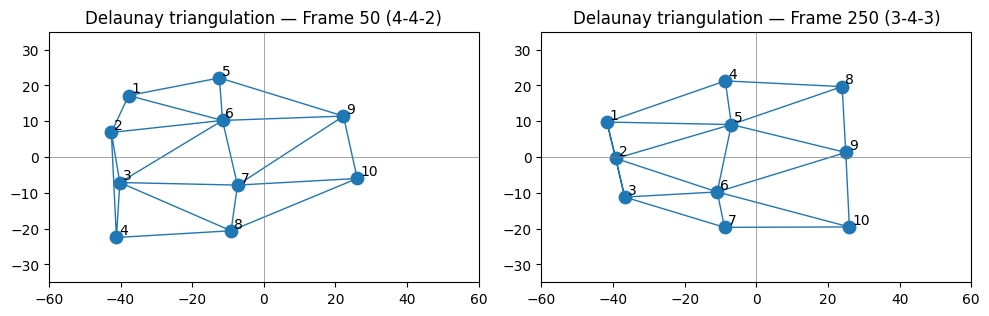

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_delaunay(ax[0], V[50],  "Delaunay triangulation — Frame 50 (4-4-2)")
plot_delaunay(ax[1], V[250], "Delaunay triangulation — Frame 250 (3-4-3)")

plt.tight_layout()
# plt.savefig("report/delany_form_change.png", dpi=250)

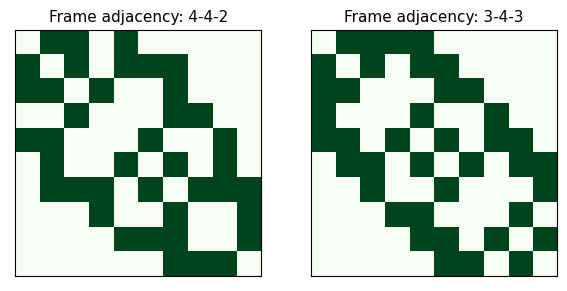

In [4]:
A_pre_frame  = A[0]
A_post_frame = A[200]
A_pre_mean   = A[:200].mean(axis=0)
A_post_mean  = A[200:].mean(axis=0)

fig1, ax1 = plt.subplots(1, 2, figsize=(7,4))
plot_adjacency_cmap(ax1[0], A_pre_frame,  "Frame adjacency: 4-4-2", cmap="Greens")
plot_adjacency_cmap(ax1[1], A_post_frame, "Frame adjacency: 3-4-3", cmap="Greens")

# plt.savefig(
#     "report/figures/A_examples.png",
#     dpi=250,
#     bbox_inches="tight",
#     pad_inches=0.02,
# )


In [5]:
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

numpy2ri.activate()

results = FormCPD.detect_formation_changes(
    A,
    fps=1,
    alpha=0.01,
    min_minutes=1,
    min_dist=10
)

Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 33.40758 
  Approximated p-value: 6.44229e-136 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 65.88859 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 33.40758 
  Approximated p-value: 2.854232e-70 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 65.88859 
  Approximated p-value: 0 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 1131.754 
  Approximated p-value: 6.124003e-244 

In [6]:
print(results)

{'change_points': [200], 'num_phases': 2, 'segments': [(0, 200), (200, 400)]}


We detect the change point at 200 !  

### Role CPD

In [7]:
from src.data import generate_synthetic_role_data
from src.RoleCPD import hamming_distance, preprocess_permutations, run_role_gseg, recursive_role_segmentation, get_dominant_perm

Total Frames: 450, Valid Frames: 450


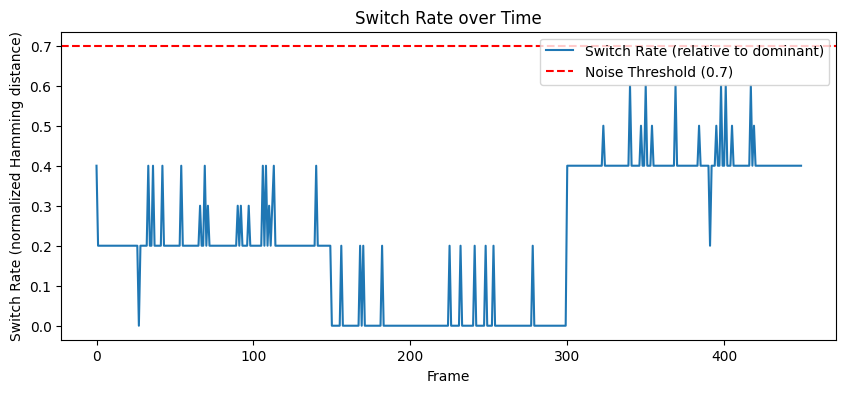

In [8]:
T, N = 450, 10
permutations = generate_synthetic_role_data(T=T, N=N, switch_times=[150, 300])

valid_idx, switch_rates = preprocess_permutations(permutations)
valid_perms = permutations[valid_idx]

print(f"Total Frames: {T}, Valid Frames: {len(valid_idx)}")
plt.figure(figsize=(10, 4))
plt.plot(switch_rates, label="Switch Rate (relative to dominant)")
plt.axhline(0.7, color='r', linestyle='--', label="Noise Threshold (0.7)")
plt.title("Switch Rate over Time")
plt.xlabel("Frame")
plt.ylabel("Switch Rate (normalized Hamming distance)")
plt.legend()
# plt.savefig("figures/RoleCPD_SwitchRate.png")

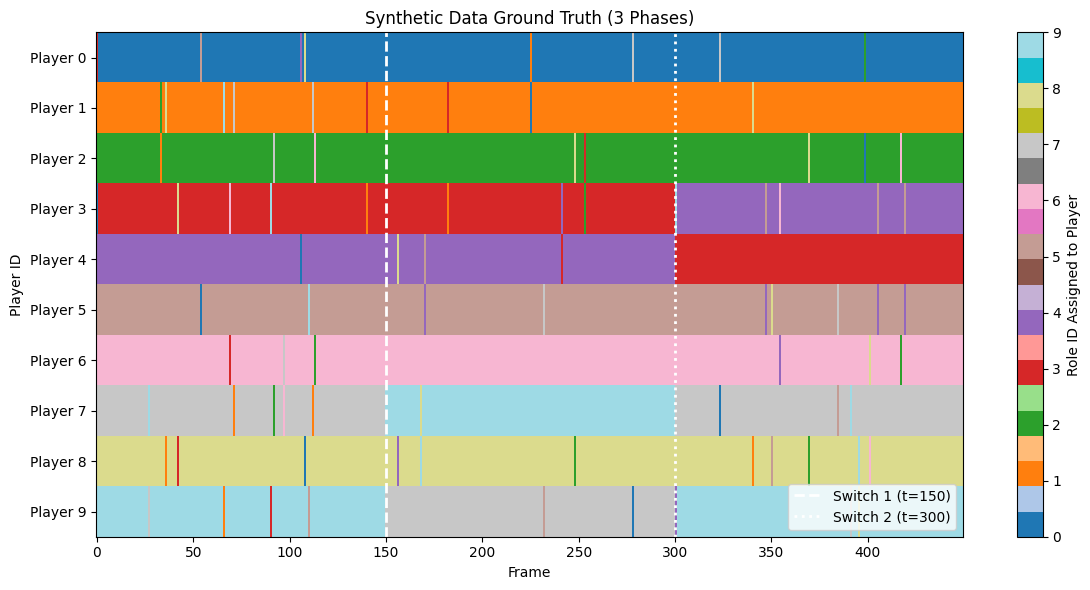

In [9]:
plt.figure(figsize=(12, 6))
plt.imshow(permutations.T, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID Assigned to Player")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.title("Synthetic Data Ground Truth (3 Phases)")
plt.axvline(150, color='white', linestyle='--', linewidth=2, label='Switch 1 (t=150)')
plt.axvline(300, color='white', linestyle=':', linewidth=2, label='Switch 2 (t=300)')
plt.legend(loc='lower right')
plt.yticks(np.arange(N), [f"Player {i}" for i in range(N)])
plt.tight_layout()
# plt.savefig("../figures/RoleCPD_GroundTruth.png")
# plt.show()

In [10]:
# Run detection on valid frames
tau_idx, pval = run_role_gseg(valid_perms)

# Map back to original time frame
detected_change_point = valid_idx[tau_idx]

print(f"Detected Change Point (Original Frame Index): {detected_change_point}")
print(f"P-value: {pval}")
print(f"True Change Point: {150}")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 14436.21 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 41569.11 
  Approximated p-value: 0 
Detected Change Point (Original Frame Index): 300
P-value: 0.0
True Change Point: 150


In [11]:
detected_cps = recursive_role_segmentation(valid_perms, valid_idx, alpha=0.01, min_seg_len=50)

print("\nFinal Detected Change Points:", detected_cps)
print("True Change Points: [150, 300]")

Generalized edge-count statistic (a) : 
  Estimated change-point location: 300 
  Test statistic: 14436.21 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 300 
  Test statistic: 41569.11 
  Approximated p-value: 0 
Significant Change Detected at Frame 300 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 9 8 7]
Right Dominant: [0 1 2 4 3 5 6 7 8 9]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 150 
  Test statistic: 16730.02 
  Approximated p-value: 0 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 150 
  Test statistic: 7249.992 
  Approximated p-value: 0 
Significant Change Detected at Frame 150 (p=0.00e+00)
Left Dominant: [0 1 2 3 4 5 6 7 8 9]
Right Dominant: [0 1 2 3 4 5 6 9 8 7]
Generalized edge-count statistic (a) : 
  Estimated change-point location: 114 
  Test statistic: 3.698663 
  Approximated p-value: 1 
Generalized edge-count statistic (u) : 
  Estimated change-point lo

R[write to console]: Error in integrate(integrandG_a, 0, 2 * pi, t = t, subdivisions = 3000,  : 
  non-finite function value

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In sqrt(varw_a) :
R[write to console]:  NaNs produced



Error running g-segmentation in R: Error in integrate(integrandG_a, 0, 2 * pi, t = t, subdivisions = 3000,  : 
  non-finite function value

Generalized edge-count statistic (a) : 
  Estimated change-point location: 118 
  Test statistic: 4.103573 
  Approximated p-value: 1 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 120 
  Test statistic: 11.65636 
  Approximated p-value: 0.0686315 

Final Detected Change Points: [150, 300]
True Change Points: [150, 300]


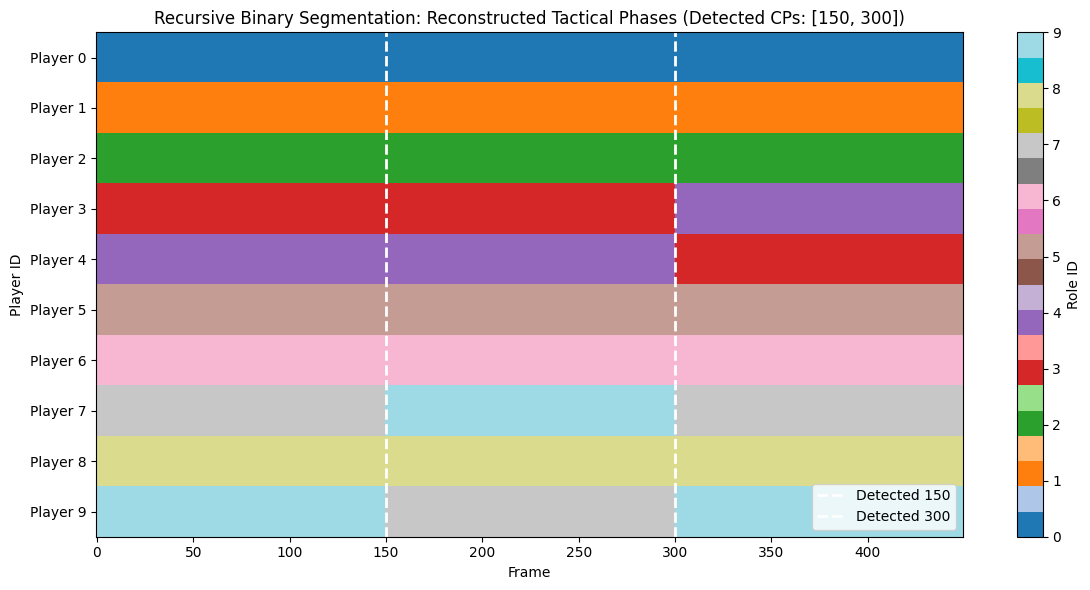

In [12]:
# Visualization of Detected Phases
plt.figure(figsize=(12, 6))

timeline_map = np.zeros((10, T)) # 10 players, T frames
boundaries = [0] + detected_cps + [T]

for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i+1]
    
    # Get permutations belonging to this interval
    mask = (valid_idx >= start) & (valid_idx < end)
    if np.any(mask):
        interval_perms = valid_perms[valid_idx[mask]]
        # Calculate dominant permutation for this specific phase
        phase_perm = get_dominant_perm(interval_perms)
    else:
        # If no valid frames in this segment (e.g. pure noise segment)
        phase_perm = np.arange(10) 
        
    # Fill timeline
    for t in range(start, end):
        timeline_map[:, t] = phase_perm

# Plotting
plt.imshow(timeline_map, aspect='auto', cmap='tab20', interpolation='nearest')
plt.colorbar(label="Role ID")
plt.title(f"Recursive Binary Segmentation: Reconstructed Tactical Phases (Detected CPs: {detected_cps})")
plt.xlabel("Frame")
plt.ylabel("Player ID")
plt.yticks(np.arange(10), [f"Player {k}" for k in range(10)])

# Draw lines for detected points
for cp in detected_cps:
    plt.axvline(cp, color='white', linestyle='--', linewidth=2, label=f'Detected {cp}')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig("../figures/RoleCPD_DetectedPhases.png")

## 2. Data 

In [13]:
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from statsbombpy import sb
from src.data import FitogetherDiagnosis

In [14]:
PITCH_LENGTH = 105.0  # Meters
PITCH_WIDTH = 68.0    # Meters
METRIC_X_RANGE = [-PITCH_LENGTH / 2, PITCH_LENGTH / 2]
METRIC_Y_RANGE = [-PITCH_WIDTH / 2, PITCH_WIDTH / 2]

In [15]:
# Constants & Configuration
ugp_data_path = 'data/ugp/17985.ugp'

In [16]:
# Fitogether Analysis
fitogether = FitogetherDiagnosis(data_path=ugp_data_path)
gps_data = fitogether.load_or_generate_data(PITCH_LENGTH,PITCH_WIDTH)
fitogether.diagnose_signal_quality()
fitogether.verify_gaussian_assumption()

Loading data from data/ugp/17985.ugp.
ugp
Format: Last Row (0-100). Transforming...

--- [Fitogether] Orientation Check ---
Player X Medians Range: -11.89 to 14.01
Orientation is left to right. No changes made.

--- [Fitogether] Signal Diagnosis ---
Completeness Check: 100.0000% available (Missing: 0.0000%)
Signal completeness is acceptable.
Jitter Analysis (Speed Std Dev) for player 1365.0: 1.34 m/s
High-frequency jitter detected (consistent with raw GPS).

--- [Fitogether] Gaussian Assumption Check ---
Testing Role Cluster #9 (N=500):
P-value (X-coord): 6.61e-08
P-value (Y-coord): 6.17e-06
Significant deviation from Normality (p < 0.05) found.


We find that the SoccerCPD data is complete with minimal missing values. We observe high-frequency jitter in the player trajectories, consistent with raw GPS data. There are significant deviations from the Gaussian assumption in player movements, as players hold positions (zones, often rectangular or irregular) and make tactical maneuvers. This indicates the need for robust modeling techniques, therefore justifies the use of the Change Point Detection (CPD) approach.

### StatsBomb

In [17]:
from src.data import StatsBombAdapter
from src.plots import generate_heatmap_comparison

In [18]:
# StatsBomb Analysis
sb_adapter = StatsBombAdapter(match_id=15946) # Barcelona Match
success = sb_adapter.fetch_and_transform(PITCH_LENGTH, PITCH_WIDTH)

sb_adapter.diagnose_sparsity()
# Create pseudo-trajectories to prove we can adapt the data
pseudo_traj = sb_adapter.construct_pseudo_trajectories(window_min=5)


--- [StatsBomb] Fetching Event Data (Match ID: 15946) ---


/home/fotis/MVA/TimeSeries/MiniProject/.venv/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(



--- [StatsBomb] Sparsity Diagnosis ---
Total Location Events: 3741
Temporal Density: 41.57 events/min (for whole team)
Per Player Density: ~1.89 events/min
Comparison: 1.89 events/min per player vs 600 frames/min in Fitogether GPS.

--- [StatsBomb] Constructing Pseudo-Trajectories (5 min windows) ---
Generated 388 pseudo-trajectory points (centroids).


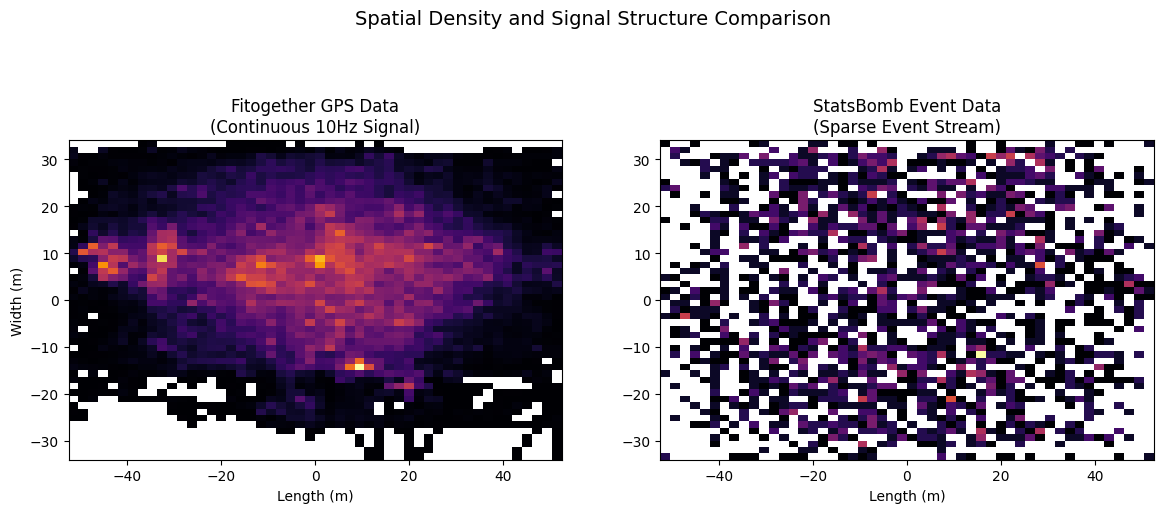

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
generate_heatmap_comparison(ax, gps_data,sb_adapter.events, METRIC_X_RANGE, METRIC_Y_RANGE)
plt.savefig("figures/data-heatmap_comparison.png")

## 3.Experiments

### 1. Experiments on SoccerCPD directly

#### Method Sweep 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from src.soccercpd_exp_utils import run_formcpd
from src.data import load_and_prepare_match
from src.plots import plot_method_cmap, plot_n_segments, plot_cp_timeline, plot_method_cp_timeline
from src.utils import pairwise_agreement, save_results, load_results
from soccercpd.myconstants import (
    MAX_SWITCH_RATE,
    MAX_PVAL,
    MIN_PERIOD_DUR,
    MIN_FORM_DIST,
)


In [21]:
def method_sweep(match,methods):
    results = {}

    for method in methods:
        print(f"\nRunning FormCPD with method = {method}")
        out = run_formcpd(match, formcpd_type=method)
        results[method] = out

        print(f"  → #segments = {out['n_segments']}")
        print(f"  → CPs:")
        for cp in out["change_points"]:
            print(f"     {cp}")

    return results


In [22]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######
methods = [
        "gseg_avg",
        "gseg_union",
        "kernel_rbf",
        "kernel_linear"]

match = load_and_prepare_match(17985)
# results = method_sweep(match, methods)
# save_results(results, "results/method_results.pkl")
results = load_results("results/method_results.pkl")

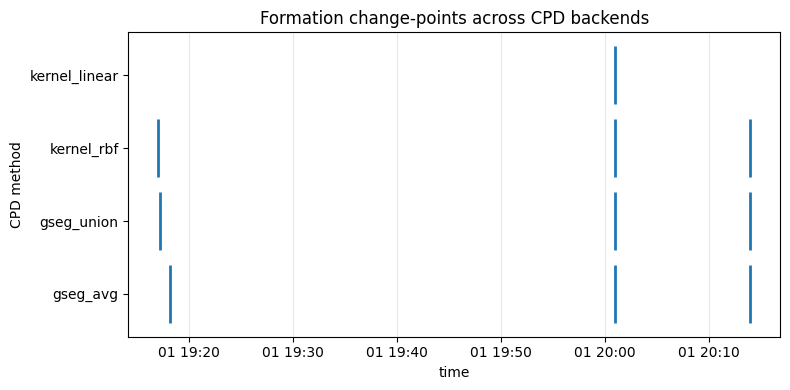

In [23]:
plot_method_cp_timeline(
    results,
    title="Formation change-points across CPD backends",
)
plt.savefig("figures/CPD_backends.png")


#### Parameter Sweep 


In [24]:
def sweep_param(
    match,
    param_name: str,
    values,
    formcpd_type: str = "gseg_avg",
    min_pdur: int = MIN_PERIOD_DUR,
    min_fdist: int = MIN_FORM_DIST,
    max_pval: float = MAX_PVAL,
):
    assert param_name in {"min_pdur", "min_fdist", "max_pval"}

    results = {}

    for v in values:
        print(f"\n[Exp2] {param_name} = {v}")

        # explicit override, no hidden kwargs
        out = run_formcpd(
            match,
            formcpd_type=formcpd_type,
            min_pdur=v if param_name == "min_pdur" else min_pdur,
            min_fdist=v if param_name == "min_fdist" else min_fdist,
            max_pval=v if param_name == "max_pval" else max_pval,
        )

        results[v] = out

        print(f"  #segments = {out['n_segments']}")
        for cp in out["change_points"]:
            print(f"    CP @ {cp}")

    return results


In [25]:
match = load_and_prepare_match(17985)

In [26]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######


# res_time = sweep_param(match,param_name="min_pdur",values=[120, 300, 600])
# save_results(res_time, "results/res_time.pkl")

res_time = load_results("results/res_time.pkl")

In [27]:
####### UNCOMMENT TO RUN EXPERIMENT OTHERWISE LOAD ALREADY CALCULATED DATA ######

# res_dist = sweep_param(match,param_name="min_fdist",values=[3, 7,12])
# save_results(res_dist, "results/res_dist.pkl")

res_dist = load_results("results/res_dist.pkl")

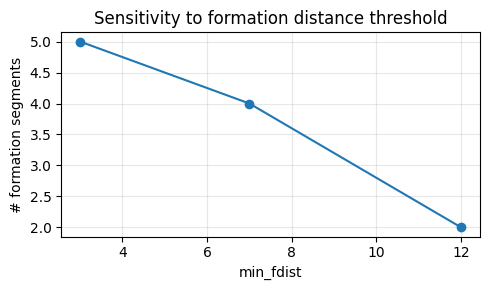

In [28]:
plot_n_segments(
    res_dist,
    xlabel="min_fdist",
    title="Sensitivity to formation distance threshold",
)
plt.savefig("figures/min_fdist.png")

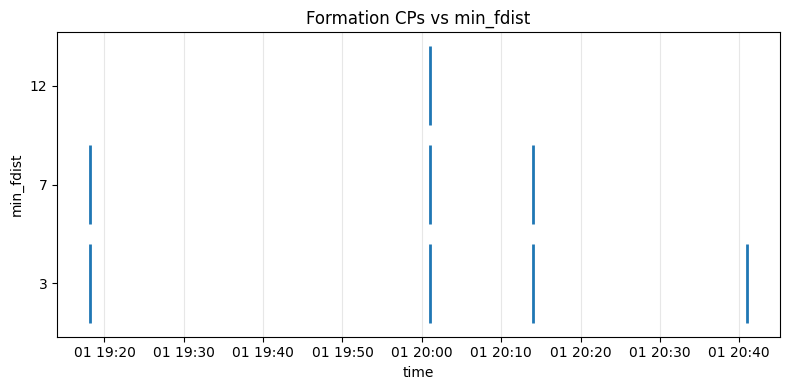

In [29]:
plot_cp_timeline(
    res_dist,
    xlabel="min_fdist",
    title="Formation CPs vs min_fdist",
)
plt.savefig("figures/exp2_cp_timeline_min_fdist.png")

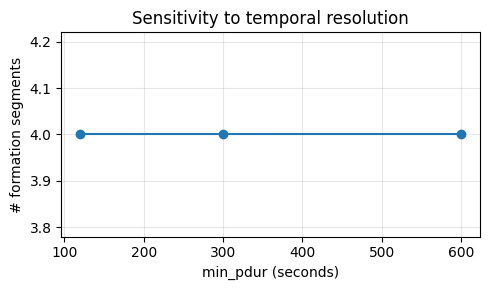

In [30]:
plot_n_segments(
    res_time,
    xlabel="min_pdur (seconds)",
    title="Sensitivity to temporal resolution",
)
plt.savefig("figures/exp2_segments_vs_min_pdur.png")

### 2. Offensive and Defensive Formation Change Point Detection (FormCPD)

In [31]:
from src.data import FitogetherDiagnosis, get_stitched_tensor
from src.plots import plot_formation
from src import FormCPD
import sys
import numpy as np
PITCH_LENGTH = 105.0  # Meters
PITCH_WIDTH = 68.0    # Meters
METRIC_X_RANGE = [-PITCH_LENGTH / 2, PITCH_LENGTH / 2]
METRIC_Y_RANGE = [-PITCH_WIDTH / 2, PITCH_WIDTH / 2]
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

numpy2ri.activate()
gSeg = importr("gSeg")

import seaborn as sns

In [32]:
# Data
# We provide several UGP files in the 'data/ugp/' directory.
# Each file corresponds to a different match.
# The '17985.ugp' file is from the K-League (South Korea), provided by Fitogether.
# The 7 digit files are from the A-League (Australia), provided by SkillCorner.
# The 'Real_vs_Barcelona_Calma.ugp' file is provided by Last Row, as part of the Friends of Tracking initiative. Note that it only contains one play and not a full match.

fitogether = FitogetherDiagnosis(data_path='data/ugp/1925299.parquet')
gps_data = fitogether.load_or_generate_data(PITCH_LENGTH, PITCH_WIDTH)

Loading data from data/ugp/1925299.parquet.
parquet
Format: Metric (Centered). No transformation needed.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -15.41 to 23.57
Orientation is left to right. No changes made.


In [33]:
# Stitching
print("Stitching trajectories to handle substitutions")
X_full = get_stitched_tensor(gps_data, n_slots=10)
# New shape should be (T x 10 x 2)
print(f"New Tensor Shape: {X_full.shape}.")

Stitching trajectories to handle substitutions
Stitched Player 560988 into Slot 19
Stitched Player 795533 into Slot 20
Stitched Player 966115 into Slot 21
Stitched Player 51722 into Slot 15
Stitched Player 795541 into Slot 16
Stitched Player 965698 into Slot 17
Stitched Player 809869 into Slot 14
Stitched Player 333110 into Slot 13
Stitched Player 966113 into Slot 12
Found 23 distinct tracks. Keeping top 10 by duration.


New Tensor Shape: (47942, 10, 2).


In [34]:
# Imputation
if np.isnan(X_full).any():
    print(f"Found {np.isnan(X_full).sum()} NaN values in trajectory data. Imputing...")
    for p in range(X_full.shape[1]):
        for dim in range(2):
            series = pd.Series(X_full[:, p, dim])
            series = series.interpolate(method='linear', limit_direction='both')
            series = series.fillna(method='bfill').fillna(method='ffill')
            X_full[:, p, dim] = series.values

    # Safety check for empty tracks
    if np.isnan(X_full).any():
        print("Warning: Replacing remaining NaNs with 0.")
        X_full = np.nan_to_num(X_full, nan=0.0)

In [35]:
# Phase Classification
# Calculate Team Centroid (average X position) per frame
team_centroid_x = np.mean(X_full[:, :, 0], axis=1)

# Define thresholds for attack and defense
ATTACK_THRESH = 5.0
DEFENSE_THRESH = -5.0

idx_attack = np.where(team_centroid_x > ATTACK_THRESH)[0]
idx_defense = np.where(team_centroid_x < DEFENSE_THRESH)[0]

print(f"Identified {len(idx_attack)} attacking frames and {len(idx_defense)} defensive frames.")

Identified 20952 attacking frames and 16981 defensive frames.


In [36]:
###### UNCOMMENT TO CALCULATE ##########

# EM-Hungarian Role Assignment
mu_global, roles_global = FormCPD.em_hungarian(X_full, n_iter=10)
np.save("results/mu_global.npy", mu_global)
np.save("results/roles_global.npy", roles_global)

# mu_global, roles_global = np.load("results/mu_global.npy"), np.load("results/roles_global.npy")

EM-Hungarian:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]

EM-Hungarian: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.45s/it]


In [37]:
sys.setrecursionlimit(100)

T = X_full.shape[0]

# Align positions based on roles
X_roles = np.zeros_like(X_full)
for t in range(T):
    current_roles = roles_global[t]
    player_indices = np.argsort(current_roles)
    X_roles[t] = X_full[t, player_indices]

# Build graphs
subsample_rate = 60 
X_sub = X_roles[::subsample_rate]
valid_frames = np.arange(0, T, subsample_rate)

A_sequence = []
for t in range(len(X_sub)):
    # Calculate adjacency matrix
    try:
        adj = FormCPD.delaunay_adjacency(X_sub[t])
        A_sequence.append(adj)
    except Exception as e:
        # Fallback
        A_sequence.append(np.zeros((10, 10)))

A_sequence = np.array(A_sequence)

# Detect Changes 
print("Running Detection")
try:
    results = FormCPD.detect_formation_changes(
        A_sequence, 
        fps=1,            
        alpha=0.01,       
        min_minutes=5,    
        min_dist=10.0     
    )
    print("Detection complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
except Exception as e:
    # We encountered a few errors during implementation
    print(f"Crash or error during detection: {e}")
    print("Using Python method instead.")
    results = detect_formation_changes_python(A_sequence, min_minutes=5, n_bkps=4)
    detected_frames = [valid_frames[cp] for cp in results['change_points'] if cp < len(valid_frames)]
    print(f"Detection Complete.")
    print(f"Detected {results['num_phases']} Phase{'s' if results['num_phases'] != 1 else ''}.")
    print(f"Change Points (approx Frame IDs): {detected_frames}")

Running Detection
Original edge-count scan statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.64376 
  Approximated p-value: 5.63945e-42 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 15.66437 
  Approximated p-value: 1.024113e-26 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.65052 
  Approximated p-value: 1.323862e-23 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 15.62456 
  Approximated p-value: 2.857687e-25 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 215.5471 
  Approximated p-value: 5.405344e-45 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 398 
  Test statistic: 250.2208 
  Approximated p-value: 1.729159e-52 
Max-type edge-count statistic (a) : 
  Estimated change-point location: 398 
  Test statistic: 14.65052 
  Ap

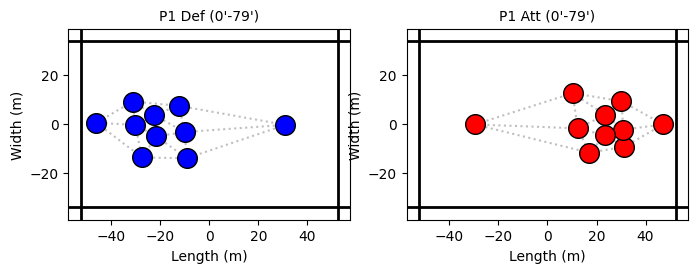

In [38]:
# Visualization of Detected Phases
n_phases = results['num_phases']
segments = results['segments']

# We limit the number of phases to plot for clarity (and to prevent OOM crashes)
MAX_PHASES_TO_PLOT = 10
if n_phases > MAX_PHASES_TO_PLOT:
    print(f"Warning: Too many phases detected ({n_phases}). Plotting first {MAX_PHASES_TO_PLOT} only.")
    n_plot = MAX_PHASES_TO_PLOT
else:
    n_plot = n_phases

# Create boolean masks 
is_attack = np.zeros(T, dtype=bool)
if 'idx_attack' in locals(): is_attack[idx_attack] = True

is_defense = np.zeros(T, dtype=bool)
if 'idx_defense' in locals(): is_defense[idx_defense] = True

# Create Figure
fig, axes = plt.subplots(n_plot, 2, figsize=(8, 4 * n_plot))
if n_plot == 1: axes = axes[:, np.newaxis]

for i in range(n_plot):
    start_sub, end_sub = segments[i]
    f_start = valid_frames[start_sub]
    f_end = valid_frames[min(end_sub, len(valid_frames)-1)]
    
    phase_data = X_roles[f_start:f_end]
    mask_att = is_attack[f_start:f_end]
    mask_def = is_defense[f_start:f_end]
    
    # Defense
    if np.any(mask_def):
        mu_def = np.nanmean(phase_data[mask_def], axis=0)
        plot_formation(axes[0, i], mu_def, f"P{i+1} Def ({f_start//600}'-{f_end//600}')", 'blue')
    else:
        axes[0, i].text(0,0, "No Data", ha='center')
        axes[0, i].axis('off')
        
    # Attack
    if np.any(mask_att):
        mu_att = np.nanmean(phase_data[mask_att], axis=0)
        plot_formation(axes[1, i], mu_att, f"P{i+1} Att ({f_start//600}'-{f_end//600}')", 'red')
    else:
        axes[1, i].text(0,0, "No Data", ha='center')
        axes[1, i].axis('off')


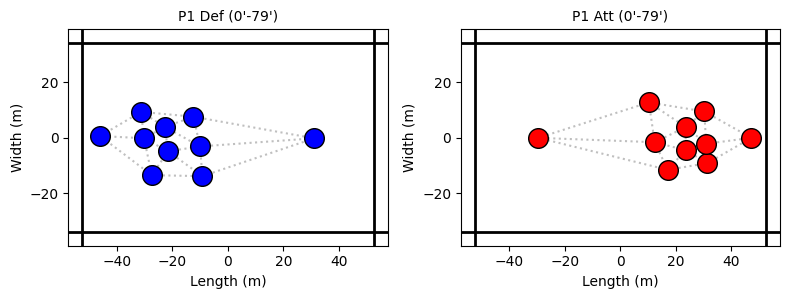

In [39]:
# Visualization of Detected Phases
n_phases = results['num_phases']
segments = results['segments']

# We limit the number of phases to plot for clarity (and to prevent OOM crashes)
MAX_PHASES_TO_PLOT = 10
if n_phases > MAX_PHASES_TO_PLOT:
    print(f"Warning: Too many phases detected ({n_phases}). Plotting first {MAX_PHASES_TO_PLOT} only.")
    n_plot = MAX_PHASES_TO_PLOT
else:
    n_plot = n_phases

# Create boolean masks 
is_attack = np.zeros(T, dtype=bool)
if 'idx_attack' in locals(): is_attack[idx_attack] = True

is_defense = np.zeros(T, dtype=bool)
if 'idx_defense' in locals(): is_defense[idx_defense] = True

# Create Figure
fig, axes = plt.subplots(n_plot, 2, figsize=(8, 4 * n_plot))
if n_plot == 1: axes = axes[:, np.newaxis]

for i in range(n_plot):
    start_sub, end_sub = segments[i]
    f_start = valid_frames[start_sub]
    f_end = valid_frames[min(end_sub, len(valid_frames)-1)]
    
    phase_data = X_roles[f_start:f_end]
    mask_att = is_attack[f_start:f_end]
    mask_def = is_defense[f_start:f_end]
    
    # Defense
    if np.any(mask_def):
        mu_def = np.nanmean(phase_data[mask_def], axis=0)
        plot_formation(axes[0, i], mu_def, f"P{i+1} Def ({f_start//600}'-{f_end//600}')", 'blue')
    else:
        axes[0, i].text(0,0, "No Data", ha='center')
        axes[0, i].axis('off')
        
    # Attack
    if np.any(mask_att):
        mu_att = np.nanmean(phase_data[mask_att], axis=0)
        plot_formation(axes[1, i], mu_att, f"P{i+1} Att ({f_start//600}'-{f_end//600}')", 'red')
    else:
        axes[1, i].text(0,0, "No Data", ha='center')
        axes[1, i].axis('off')

plt.tight_layout()

### 3. Player Stationarity Analysis

In [40]:
def calculate_player_stationarity(X_tensor, segments, attack_indices, defense_indices):
    """
    Calculates the spatial standard deviation (stationarity) of players for each formation phase, split by Attack and Defense.
    
    Lower Std Dev = Higher Stationarity (Fixed Position)
    Higher Std Dev = Lower Stationarity (Free Roaming)
    """
    stationarity_results = []

    for phase_id, (start, end) in enumerate(segments):
        # Define time range for this phase
        phase_frames = np.arange(start, end)
        
        # Intersect phase frames with Attack/Defense frames
        phase_att_idx = np.intersect1d(phase_frames, attack_indices)
        phase_def_idx = np.intersect1d(phase_frames, defense_indices)
        
        # Calculate metrics for Attack
        if len(phase_att_idx) > 10:
            pos_att = X_tensor[phase_att_idx] 
            means_att = np.nanmean(pos_att, axis=0)
            dists_att = np.linalg.norm(pos_att - means_att, axis=2)

            # Stationarity Metric: Standard Deviation of distances (Spread)
            std_att = np.nanstd(dists_att, axis=0)
        else:
            std_att = np.zeros(X_tensor.shape[1])

        # Calculate metrics for Defense
        if len(phase_def_idx) > 10:
            pos_def = X_tensor[phase_def_idx]
            means_def = np.nanmean(pos_def, axis=0)
            dists_def = np.linalg.norm(pos_def - means_def, axis=2)
            std_def = np.nanstd(dists_def, axis=0)
        else:
            std_def = np.zeros(X_tensor.shape[1])
            
        stationarity_results.append({
            'phase': phase_id,
            'attack_std': std_att,
            'defense_std': std_def
        })
        
    return stationarity_results

In [41]:
# Extract segments from detection results
det_segments_sub = results['segments']
det_segments_full = [(s*subsample_rate, e*subsample_rate) for s, e in det_segments_sub]

stat_metrics = calculate_player_stationarity(X_full, det_segments_full, idx_attack, idx_defense)

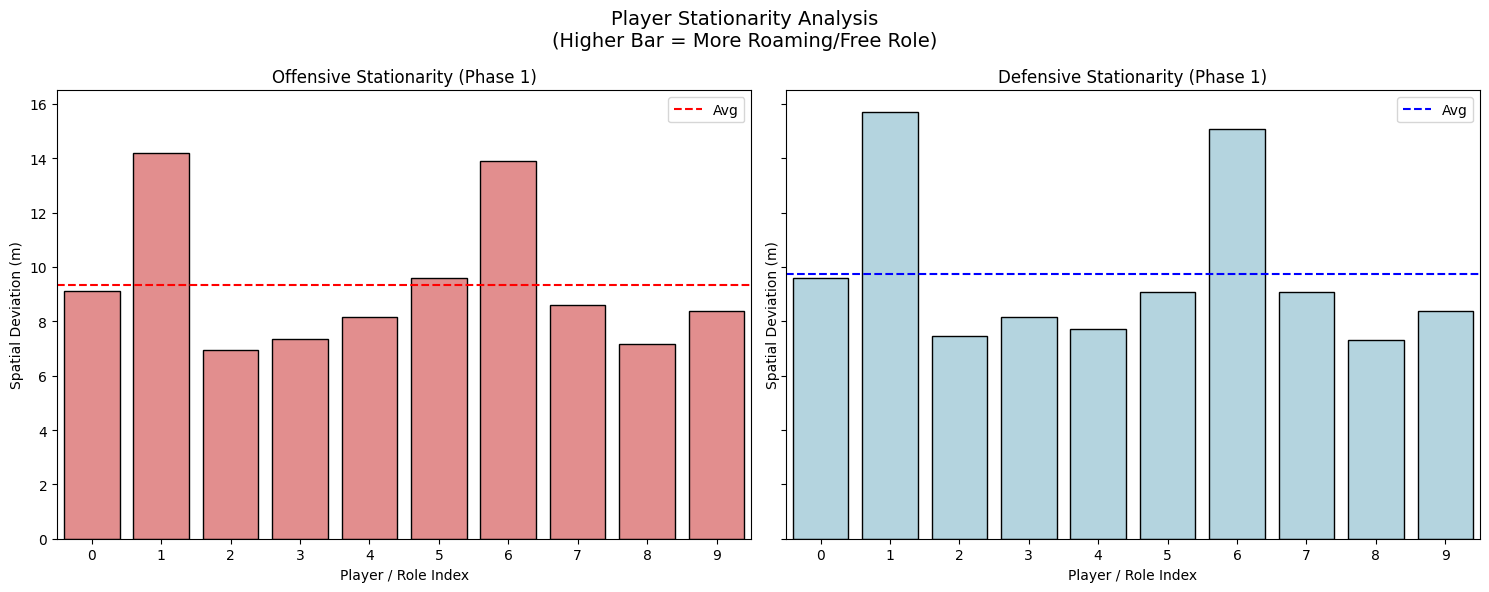

In [42]:
# Visualization of Stationarity Metrics
target_phase = 0 
data = stat_metrics[target_phase]

n_players = len(data['attack_std'])
player_ids = np.arange(n_players)

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Offensive Stationarity
sns.barplot(x=player_ids, y=data['attack_std'], ax=ax[0], color='lightcoral', edgecolor='black')
ax[0].set_title(f"Offensive Stationarity (Phase {target_phase+1})")
ax[0].set_xlabel("Player / Role Index")
ax[0].set_ylabel("Spatial Deviation (m)")
ax[0].axhline(np.mean(data['attack_std']), color='red', linestyle='--', label='Avg')
ax[0].legend()

# Defensive Stationarity
sns.barplot(x=player_ids, y=data['defense_std'], ax=ax[1], color='lightblue', edgecolor='black')
ax[1].set_title(f"Defensive Stationarity (Phase {target_phase+1})")
ax[1].set_xlabel("Player / Role Index")
ax[1].set_ylabel("Spatial Deviation (m)")
ax[1].axhline(np.mean(data['defense_std']), color='blue', linestyle='--', label='Avg')
ax[1].legend()

plt.suptitle("Player Stationarity Analysis\n(Higher Bar = More Roaming/Free Role)", fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
# Identify the 'Roamer' (Max deviation in Attack)
roamer_idx = np.argmax(data['attack_std'])
print(f"Most active roamer in Attack: Player/Role {roamer_idx} ({data['attack_std'][roamer_idx]:.2f}m deviation)")

# Identify the 'Roamer' (Max deviation in Defense)
roamer_idx = np.argmax(data['defense_std'])
print(f"Most active roamer in Defense: Player/Role {roamer_idx} ({data['defense_std'][roamer_idx]:.2f}m deviation)")


Most active roamer in Attack: Player/Role 1 (14.20m deviation)
Most active roamer in Defense: Player/Role 1 (15.71m deviation)


### 4. StatsBomb Event Data

In [44]:
comps = sb.competitions()
la_liga = comps[(comps['country_name'] == 'Spain') & (comps['competition_name'] == 'La Liga')]
season = la_liga.sort_values('season_name', ascending=False).iloc[0]
print(f"Selected Season: {season['season_name']}")

# Get Matches
matches = sb.matches(competition_id=season['competition_id'], season_id=season['season_id'])
barca_matches = matches[(matches['home_team'] == 'Barcelona') | (matches['away_team'] == 'Barcelona')]

# Pick the first match
target_match = barca_matches.iloc[0]
match_id = target_match['match_id']
print(f"Selected Match: Barcelona vs {target_match['away_team'] if target_match['home_team']=='Barcelona' else target_match['home_team']} (ID: {match_id})")

# Load Events
events = sb.events(match_id=match_id)
print(f"Loaded {len(events)} events.")

/home/fotis/MVA/TimeSeries/MiniProject/.venv/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


Selected Season: 2020/2021
Selected Match: Barcelona vs Deportivo Alavés (ID: 3773386)
Loaded 3891 events.


In [45]:
# Preprocessing & Imputation
loc_events = events[events['location'].notna()].copy().reset_index(drop=True)
locs = np.vstack(loc_events['location'].values)

loc_events['sb_x'] = locs[:, 0]
loc_events['sb_y'] = locs[:, 1]

PITCH_LENGTH = 105.0
PITCH_WIDTH = 68.0
# Transform to Metric (Centered)
# X: 0..120 -> -52.5..52.5
loc_events['std_x'] = (loc_events['sb_x'] / 120.0 * PITCH_LENGTH) - (PITCH_LENGTH / 2)
# Y: 0..80 -> 34..-34
loc_events['std_y'] = (PITCH_WIDTH / 2) - (loc_events['sb_y'] / 80.0 * PITCH_WIDTH)
events = loc_events

# Create Continuous Time Grid
events['seconds'] = events['minute'] * 60 + events['second']

max_time = events['seconds'].max()
time_grid = np.arange(0, max_time + 1)

# Identify Top 10 Players
player_event_counts = events[events['team'] == 'Barcelona']['player'].value_counts()
top_10_players = player_event_counts.head(10).index.tolist()
print(f"Selected Top 10 Players: {top_10_players}")

# Build Trajectory Tensor X (Time x Players x 2)
X_barca = np.full((len(time_grid), len(top_10_players), 2), np.nan)

for i, player_name in enumerate(top_10_players):
    # Filter events for the player
    p_df = events[events['player'] == player_name]
    
    # Handle duplicate timestamps by averaging positions
    p_events_unique = p_df.groupby('seconds')[['std_x', 'std_y']].mean()
    
    # Reindex to the full time grid
    p_trace = p_events_unique.reindex(time_grid)
    
    # Forward Fill: Assume player stays in place until their next action
    p_trace = p_trace.ffill(limit=60) 
    
    # Fill remaining NaNs with Backward Fill
    p_trace = p_trace.bfill()
    p_trace = p_trace.fillna(0)
    
    X_barca[:, i, :] = p_trace.values

print(f"Constructed Imputed Trajectory Tensor: {X_barca.shape}")


Selected Top 10 Players: ['Frenkie de Jong', 'Gerard Piqué Bernabéu', 'Sergi Roberto Carnicer', 'Lionel Andrés Messi Cuccittini', 'Miralem Pjanić', 'Clément Lenglet', 'Anssumane Fati', 'Pedro González López', 'Jordi Alba Ramos', 'Sergio Busquets i Burgos']
Constructed Imputed Trajectory Tensor: (5694, 10, 2)


In [46]:
# EM-Hungarian
mu_barca, roles_barca = FormCPD.em_hungarian(X_barca, n_iter=10)

X_barca_metric = np.zeros_like(X_barca)
for t in range(len(X_barca)):
    X_barca_metric[t] = X_barca[t, roles_barca[t]]

# Build Adjacency Matrices
print("Building Adjacency Matrices")
A_barca_seq = []
valid_frames = np.arange(len(X_barca_metric))

for t in valid_frames:
    try:
        # Calculate Delaunay adjacency for the 10 players at time t
        adj = FormCPD.delaunay_adjacency(X_barca_metric[t])
        A_barca_seq.append(adj)
    except:
        A_barca_seq.append(np.zeros((10, 10)))

A_barca_seq = np.array(A_barca_seq)

# Detect Formation Changes
print("Detecting Formation Changes")
results_barca = FormCPD.detect_formation_changes(
    A_barca_seq,
    fps=1,            # Data is 1 frame per second
    alpha=0.05,       # Significance level
    min_minutes=5,    # Minimum phase duration (e.g., 5 mins)
    min_dist=5        # Minimum separation
)

print(f"Detected {results_barca['num_phases']} phases.")
print(f"Segments: {results_barca['segments']}")

EM-Hungarian:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]

EM-Hungarian: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Building Adjacency Matrices
Detecting Formation Changes
Original edge-count statistic (a): p-value approximation without skewness correction is reported.
Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (a): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (a): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 2864 
  Test statistic: 160.4377 
  Approximated p-value: 0 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 2853 
  Test statistic: 310.013 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 2866 
  T

In [47]:
# Define Possession Context (Attack vs Defense) ---
possession_map = events.groupby('seconds')['possession_team'].last().reindex(time_grid).ffill()
    
# Attack: When Barcelona has the ball
idx_att_barca = np.where(possession_map == 'Barcelona')[0]
# Defense: When Barcelona does NOT have the ball (Opponent or None)
idx_def_barca = np.where(possession_map != 'Barcelona')[0]

# Iterate Detected Phases & Compute Formations
segments = results_barca['segments']
n_phases = len(segments)

print(f"Detected {n_phases} Tactical Phases.")

Detected 2 Tactical Phases.


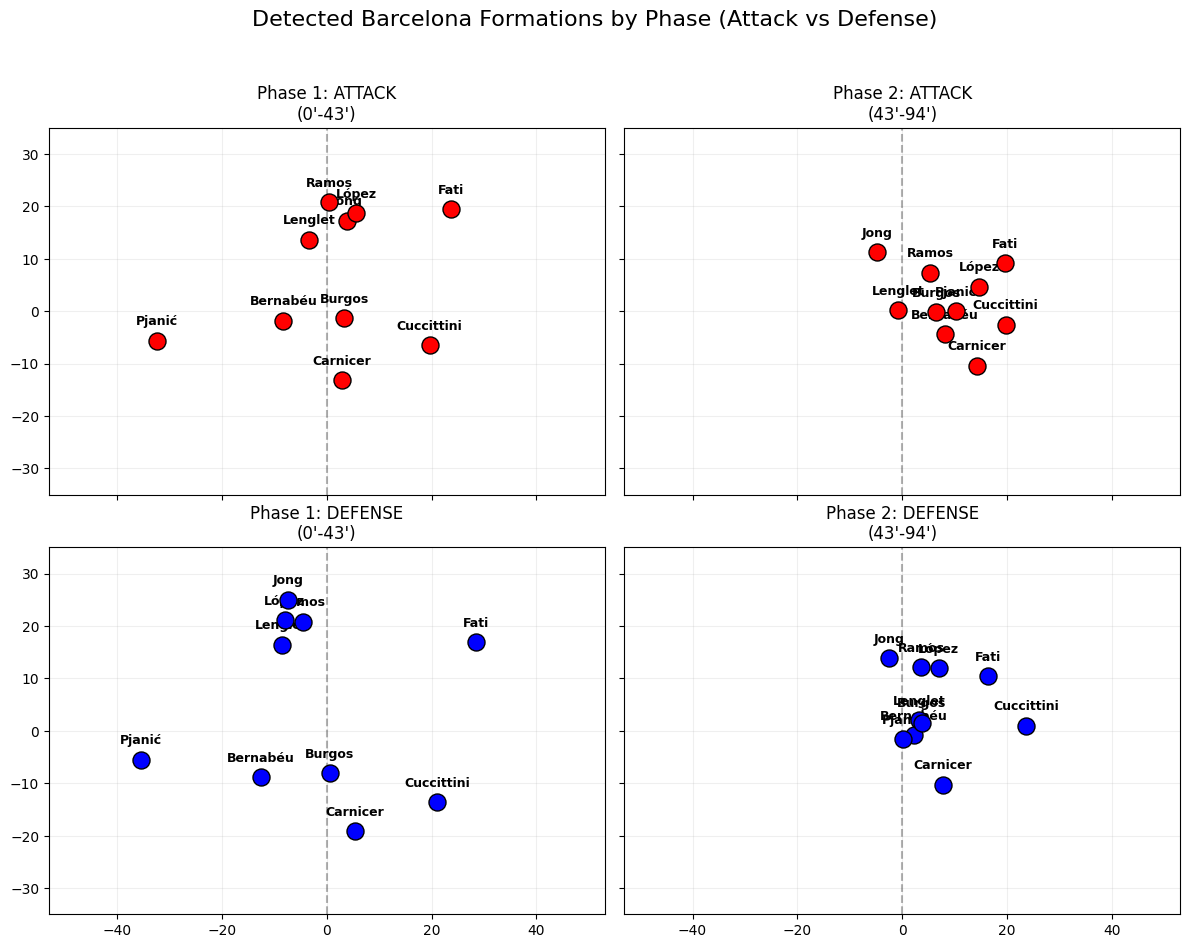

In [48]:
fig, axes = plt.subplots(2, n_phases, figsize=(6 * n_phases, 10), sharex=True, sharey=True)

if n_phases == 1:
    axes = axes[:, np.newaxis]

for i, (start, end) in enumerate(segments):
    # Indices for this specific segment
    phase_frames = np.arange(start, end)
    
    # Intersection: Segment Frames AND Attack/Defense State
    curr_att_idx = np.intersect1d(phase_frames, idx_att_barca)
    curr_def_idx = np.intersect1d(phase_frames, idx_def_barca)
    
    # Plot Attacking Formation
    ax_att = axes[0, i]
    if len(curr_att_idx) > 10:
        pos_att = X_barca_metric[curr_att_idx] 
        # Calculate Mean Position (Centroid) -> The "Formation"
        mu_att = np.nanmean(pos_att, axis=0)
        
        # Scatter Plot
        ax_att.scatter(mu_att[:, 0], mu_att[:, 1], c='red', s=150, edgecolors='k', zorder=5)
        
        # Annotate Players
        for p_idx, (px, py) in enumerate(mu_att):
            if not np.isnan(px):
                # Use last name for brevity
                name = top_10_players[p_idx].split()[-1] 
                ax_att.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
        
        ax_att.set_title(f"Phase {i+1}: ATTACK\n({start//60}'-{end//60}')")
    else:
        ax_att.text(0, 0, "Low/No Possession Data", ha='center')
        ax_att.set_title(f"Phase {i+1}: ATTACK")

    # Plot Defensive Formation
    ax_def = axes[1, i]
    if len(curr_def_idx) > 10:
        pos_def = X_barca_metric[curr_def_idx]
        mu_def = np.nanmean(pos_def, axis=0)
        
        ax_def.scatter(mu_def[:, 0], mu_def[:, 1], c='blue', s=150, edgecolors='k', zorder=5)
        
        for p_idx, (px, py) in enumerate(mu_def):
            if not np.isnan(px):
                name = top_10_players[p_idx].split()[-1]
                ax_def.text(px, py+3, name, ha='center', fontsize=9, fontweight='bold')
                
        ax_def.set_title(f"Phase {i+1}: DEFENSE\n({start//60}'-{end//60}')")
    else:
        ax_def.text(0, 0, "Low/No Defense Data", ha='center')
        ax_def.set_title(f"Phase {i+1}: DEFENSE")

    # Add Pitch
    for ax in [ax_att, ax_def]:
        ax.set_xlim(-53, 53)
        ax.set_ylim(-35, 35)
        ax.axvline(0, c='k', alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

plt.suptitle("Detected Barcelona Formations by Phase (Attack vs Defense)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [49]:
# Player Stationarity Analysis
stat_metrics_barca = calculate_player_stationarity(
    X_barca_metric,             # Role-aligned trajectory tensor
    results_barca['segments'],  # Detected formation phases
    idx_att_barca,              # Attack frames (Possession)
    idx_def_barca               # Defense frames (No Possession)
)

In [50]:
def plot_stationarity_barca(metrics, phase_idx, player_names=None):
    if phase_idx >= len(metrics):
        print(f"Phase {phase_idx+1} not found.")
        return

    data = metrics[phase_idx]
    n_roles = len(data['attack_std'])
    role_ids = np.arange(n_roles)

    # Create Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # 1. Attack Stationarity
    sns.barplot(x=role_ids, y=data['attack_std'], ax=ax[0], color='firebrick', edgecolor='black')
    ax[0].set_title(f"ATTACK Stationarity (Phase {phase_idx+1})\n(Barcelona Possession)")
    ax[0].set_xlabel("Tactical Role ID")
    ax[0].set_ylabel("Spatial Deviation (meters)")
    
    # Add average line
    avg_att = np.nanmean(data['attack_std'])
    ax[0].axhline(avg_att, color='red', linestyle='--', label=f'Avg: {avg_att:.1f}m')
    ax[0].legend()

    # 2. Defense Stationarity
    sns.barplot(x=role_ids, y=data['defense_std'], ax=ax[1], color='royalblue', edgecolor='black')
    ax[1].set_title(f"DEFENSE Stationarity (Phase {phase_idx+1})\n(Opponent Possession)")
    ax[1].set_xlabel("Tactical Role ID")
    
    # Add average line
    avg_def = np.nanmean(data['defense_std'])
    ax[1].axhline(avg_def, color='blue', linestyle='--', label=f'Avg: {avg_def:.1f}m')
    ax[1].legend()

    # Annotations
    plt.suptitle(f"Barcelona Role Stationarity: Phase {phase_idx+1}\n(Higher Bar = More Roaming / Free Role)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print numerical summary
    print(f"--- Phase {phase_idx+1} Summary ---")
    print(f"Avg Attack Deviation: {avg_att:.2f}m")
    print(f"Avg Defense Deviation: {avg_def:.2f}m")
    
    # Identify most fluid role
    most_fluid_att = np.nanargmax(data['attack_std'])
    print(f"Most Fluid Attacking Role: Role {most_fluid_att} (std: {data['attack_std'][most_fluid_att]:.2f}m)")

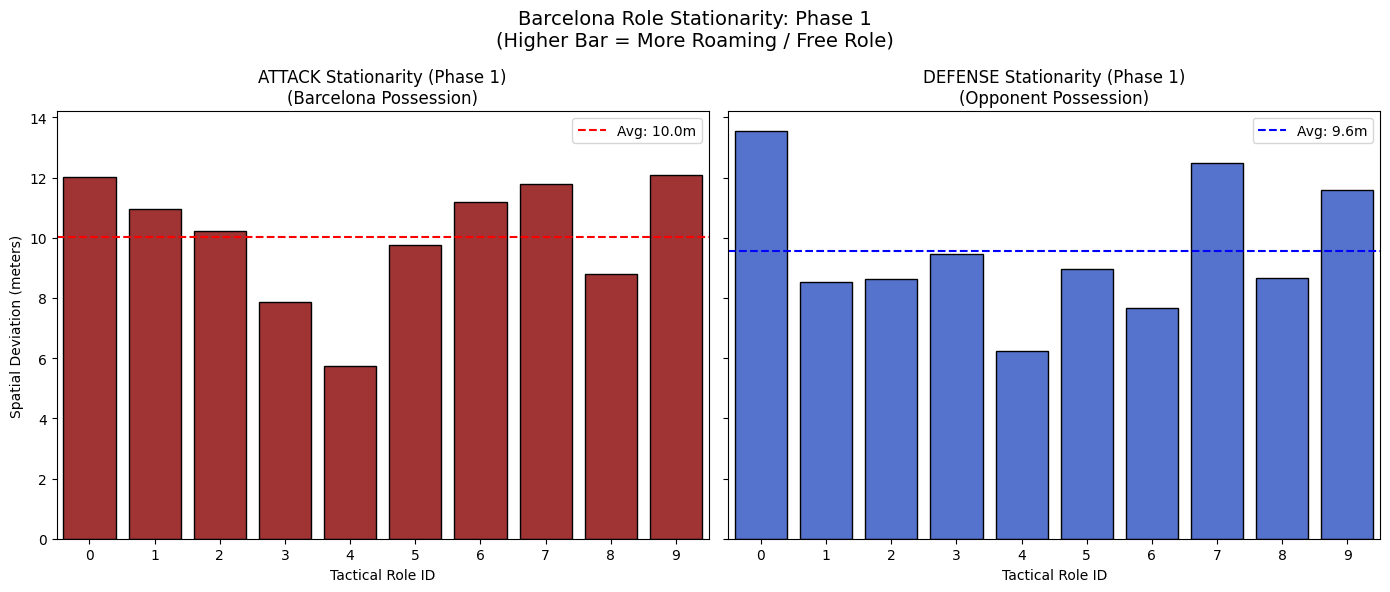

--- Phase 1 Summary ---
Avg Attack Deviation: 10.04m
Avg Defense Deviation: 9.57m
Most Fluid Attacking Role: Role 9 (std: 12.10m)


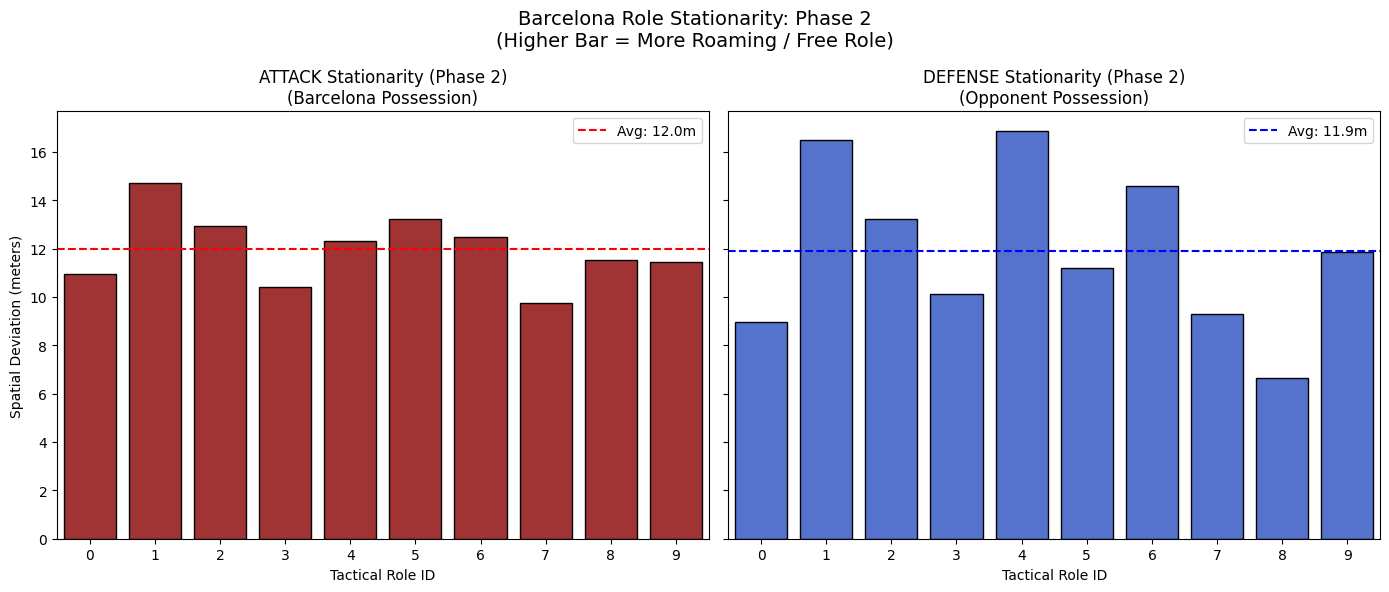

--- Phase 2 Summary ---
Avg Attack Deviation: 11.97m
Avg Defense Deviation: 11.92m
Most Fluid Attacking Role: Role 1 (std: 14.70m)


In [51]:
plot_stationarity_barca(stat_metrics_barca, phase_idx=0)

# If a second phase exists (e.g. after a substitution or tactical switch), plot that too
if len(stat_metrics_barca) > 1:
    plot_stationarity_barca(stat_metrics_barca, phase_idx=1)